In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data as Data
import matplotlib.pyplot as plt
import random

In [6]:
ratings = pd.read_csv('~/Data/clean_rating4.csv').drop(["id"], axis = 1)

idx_to_animes = list(set(ratings['anime_id'].tolist()))
idx_to_users = list(set(ratings['user_id'].tolist()))
anime_to_idx = {anime: idx for idx, anime in enumerate(idx_to_animes)}
user_to_idx = {user: idx for idx, user in enumerate(idx_to_users)}
num_users, num_animes = len(idx_to_users), len(idx_to_animes)

train_ratio = 0.9
# all_users = list(set(ratings.user_id))
# train_sample = random.sample(all_users, int(num_users * train_ratio))
# train_data = ratings[ratings.user_id.isin(train_sample)]
# test_data = list(set(all_users) - set(train_sample))
# print(train_data.shape)

data_ps = np.array(ratings.values.tolist())
train_data = data_ps[:int(train_ratio * len(data_ps))]
test_data = data_ps[int(train_ratio * len(data_ps)):]
print(train_data.shape, test_data.shape)

from collections import defaultdict
user_item_dic, data, labels = defaultdict(list), [], []
for d in train_data:
    user_item_dic[user_to_idx[d[0]]].append(anime_to_idx[d[1]])
    data.append([user_to_idx[d[0]], anime_to_idx[d[1]]])
    if d[2] != -1:
        labels.append(d[2] / 10)
    else:
        labels.append(fill_rating(anime_to_idx[d[1]]))

(2084856, 3) (231651, 3)


In [5]:
hot_items = get_hot_items()
keys, animes = hot_items.keys(), [i for i in range(num_animes)]
def fill_rating(anime_id):
    return hot_items[anime_id]

In [4]:
def get_hot_items():
    animes = pd.read_csv("~/Data/anime.csv")
    animes = animes[animes["anime_id"].isin(idx_to_animes)].loc[:, ["anime_id", "rating", "members"]].fillna(0)

    scalar = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    animes["rating_norm"] = animes[["rating"]].apply(scalar)
    animes["members_norm"] = animes[["members"]].apply(scalar)
    animes["weight"] = 0.6 * animes["rating_norm"] + 0.4 * animes["members_norm"]
    animes = animes.sort_values(by = "weight", ascending = False)
    
    return {anime_to_idx[i[0]]: i[1] for i in animes[["anime_id", "weight"]].values}

In [14]:
class NCFDataset(Data.Dataset):
    def __init__(self, data_ps, users, labels):
        super(NCFDataset, self).__init__()
        self.data = data_ps
        self.users = users
        self.label = labels

    def __getitem__(self, idx):
        user = self.data[idx][0]
        item = self.data[idx][1]
        label = self.label[idx]

        return user, item, label

    def __len__(self):
#         return self.num_ng * len(self.users) + len(self.data_ps)
        return len(self.data)

In [15]:
batch_size = 10000
users = [user_to_idx[i] for i in list(set(train_data[:, 0]))]
dataset = NCFDataset(data, users, labels)

data_iter = Data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
for user, item, label in data_iter:
    print(label.shape)
    break

torch.Size([10000])


In [7]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, model, factor_num = 8, num_layers = 3,
               MLP_model = None, GMF_model = None, alpha = 0.5, dropout = 0.5):
        super(NCF, self).__init__()
        self.MLP_model = MLP_model
        self.GMF_model = GMF_model
        self.alpha = alpha
        self.dropout = dropout
        self.user_embed_GMF = nn.Embedding(num_users, factor_num)
        self.item_embed_GMF = nn.Embedding(num_items, factor_num)
        self.user_embed_MLP = nn.Embedding(num_users, factor_num * (2 ** (num_layers - 1)))
        self.item_embed_MLP = nn.Embedding(num_items, factor_num * (2 ** (num_layers - 1)))
        self.sigmoid = nn.Sigmoid()

        self.MLP = nn.Sequential(
            nn.Dropout(p = self.dropout),
            nn.Linear(factor_num * (2 ** num_layers), factor_num * (2 ** (num_layers - 1))),
            nn.ReLU()
        )
        for layer in range(num_layers - 1, 0, -1):
            self.MLP.add_module('dropout' + str(num_layers - layer), nn.Dropout(p = self.dropout))
            self.MLP.add_module('linear' + str(num_layers - layer), nn.Linear(factor_num * (2 ** layer), factor_num * (2 ** (layer - 1))))
            self.MLP.add_module('relu' + str(num_layers - layer), nn.ReLU())

        self.model = model
        if self.model in ['GMF', 'MLP']:
            self.NeuMF = nn.Linear(factor_num, 1)
        else:
            self.NeuMF = nn.Linear(2 * factor_num, 1)

        self.__init_weights__()

    def __init_weights__(self):
        if self.model in ['GMF', 'MLP']:
            nn.init.normal_(self.user_embed_GMF.weight, std = 0.01)
            nn.init.normal_(self.item_embed_GMF.weight, std = 0.01)
            nn.init.normal_(self.user_embed_MLP.weight, std = 0.01)
            nn.init.normal_(self.item_embed_MLP.weight, std = 0.01)

            for layer in self.MLP:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
#                   nn.init.normal_(layer.weight, std = 0.01)

            nn.init.kaiming_uniform_(self.NeuMF.weight, a = 1, nonlinearity = 'sigmoid')
#             nn.init.normal_(self.NeuMF.weight, std = 0.01)

        elif self.GMF_model and self.MLP_model:
            self.user_embed_GMF.weight.data.copy_(self.GMF_model.user_embed_GMF.weight)
            self.item_embed_GMF.weight.data.copy_(self.GMF_model.item_embed_GMF.weight)
            self.user_embed_MLP.weight.data.copy_(self.MLP_model.user_embed_MLP.weight)
            self.item_embed_MLP.weight.data.copy_(self.MLP_model.item_embed_MLP.weight)

            for (m1, m2) in zip(self.MLP, self.MLP_model.MLP):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            NeuMF_weight = torch.cat((self.alpha * self.GMF_model.NeuMF.weight, (1 - self.alpha) * self.MLP_model.NeuMF.weight), 1)
            NeuMF_bias = self.GMF_model.NeuMF.bias + self.MLP_model.NeuMF.bias

            self.NeuMF.weight.data.copy_(NeuMF_weight)
            self.NeuMF.bias.data.copy_(NeuMF_bias)
            
    def forward(self, user, item):
        if self.model is 'GMF' or 'NCF':
            user_embed_GMF = self.user_embed_GMF(user)
            item_embed_GMF = self.item_embed_GMF(item)
            
#             print(user_embed_GMF.device, item_embed_GMF.decive)
            GMF_output = user_embed_GMF * item_embed_GMF

        if self.model is 'MLP' or 'NCF':
            user_embed_MLP = self.user_embed_MLP(user)
            item_embed_MLP = self.item_embed_MLP(item)

            MLP_input = torch.cat((user_embed_MLP, item_embed_MLP), 1)
            MLP_output = self.MLP(MLP_input)

        if self.model is 'NCF':
            output = self.NeuMF(torch.cat((MLP_output, GMF_output), 1))
        elif self.model is 'MLP':
            output = self.NeuMF(MLP_output)
        elif self.model is 'GMF':
            output = self.NeuMF(GMF_output)
            
        return self.sigmoid(output)

In [17]:
MLP_Loss, GMF_Loss, NCF_Loss = [], [], [] 
def train(net, num_epochs, lr, train_type = 'NCF'):
    print(train_type)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     device = torch.device('cpu')
    print('train on', device)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        l_sum,n = 0, 0
        for user, item, label in data_iter:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)
            pred = net(user, item)
            l = loss(pred.view(label.shape), label.float())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.cpu().item()
            n += 1
            
        if train_type == "MLP":
            MLP_Loss.append(l_sum / n)
        elif train_type == "GMF":
            GMF_Loss.append(l_sum / n)
        elif train_type == "NCF":
            NCF_Loss.append(l_sum / n)
            
        print(epoch + 1, l_sum / n)

In [18]:
MLP_net = NCF(num_users, num_animes, model = 'MLP')
train(MLP_net, 30, lr = 0.0001, train_type = 'MLP')

GMF_net = NCF(num_users, num_animes, model = 'GMF')
train(GMF_net, 30, lr = 0.0001, train_type = 'GMF')

NCF_net = NCF(num_users, num_animes, model = 'NCF', GMF_model = GMF_net, MLP_model = MLP_net)
train(NCF_net, 30, lr = 0.0001)

MLP
train on cpu
1 0.07637518972301027
2 0.05221820521083745
3 0.03226711857689625
4 0.025586263031551714
5 0.022561474360133473
6 0.020829509319871237
7 0.019840790324233935
8 0.01929143113953075
9 0.01891704787763112
10 0.018620622928062696
11 0.018387080851995773
12 0.018172218192493515
13 0.01795292361394355
14 0.01778081880267442
15 0.01763443631882017
16 0.01746436098866771
17 0.01734035913097231
18 0.01719206664265628
19 0.017064951280016078
20 0.01693248744323208
21 0.016807032757968993
22 0.01669691246377224
23 0.016578418349749165
24 0.01648257271738714
25 0.016385821638958593
26 0.016288648074287832
27 0.016213408043010955
28 0.01614676639615919
29 0.01607758863762235
30 0.016040289885939307
GMF
train on cpu
1 0.06388760844700074
2 0.061939439402100005
3 0.059880400673624434
4 0.057226571651024113
5 0.053913637621408446
6 0.05011666854888058
7 0.0460554070093415
8 0.04193857836238505
9 0.03796918032485903
10 0.03429825112009733
11 0.031049560292058014
12 0.028275842310495354

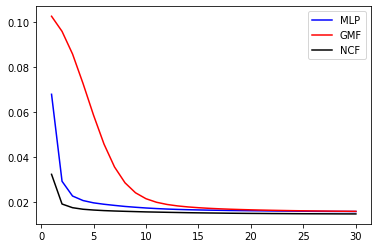

In [19]:
x_data = [n for n in range(1, 31)]
MLP_Loss = [0.05590997135453817, 0.04388035445264652, 0.03441229041968807, 0.026198633059716682,
            0.02155782455248696, 0.019717730679794362, 0.01893876972452305, 0.018484929629989218,
            0.01819698341440356, 0.017965885440698652, 0.017781578129130688, 0.01761494001204317,
            0.017471235245466232, 0.017335133662705785, 0.017221350686259247, 0.017112711979227774,
            0.01700326620320384, 0.016910347517169834, 0.01682083569823555, 0.016726248028674763,
            0.016637995424702692, 0.01655022905132417, 0.016463012929168044, 0.01637699545481416,
            0.016312729357853176, 0.016236763010826407, 0.016188110746265028, 0.016119342350788664,
            0.016046185786145157, 0.01599544869138721]
mlp, = plt.plot(x_data, MLP_Loss, color = 'blue')
gmf, = plt.plot(x_data, GMF_Loss, color = 'red')
ncf, = plt.plot(x_data, NCF_Loss, color = 'black')
plt.legend([mlp, gmf, ncf], ['MLP', 'GMF', 'NCF'])
plt.savefig("loss.jpg")
plt.show()

In [20]:
def metrics(net, test_data, bound):
    users = list(set(test_data[:,0].tolist()))
    recall, precise, f1 = [], [], []
    for user in users:
        all_items = torch.LongTensor([i for i in range(num_animes)]).cuda()
        test_user = torch.LongTensor([user for i in range(num_animes)]).cuda()
        pred = net(test_user, all_items)
#         print(pred.shape)
        _, idx = torch.topk(pred, k = 5, dim = 0)
        
        target = [anime_to_idx[i[1]] for i in ratings[ratings.user_id == user].values if i[2] > bound]
        if not target: continue
        idx = idx.cpu().numpy().flatten()
        overlap = list(set(target) & set(idx))
        recall.append(len(overlap) / len(target))
        precise.append(len(overlap) / len(idx))
        f1.append((2 * recall[-1] * precise[-1]) / (recall[-1] + precise[-1]))
#         print(recall[-1], precise[-1])
        
    return np.mean(f1)

In [ ]:
torch.save(NCF_net.state_dict(), "NCF1.pt")
torch.save(GMF_net.state_dict(), "GMF1.pt")
torch.save(MLP_net.state_dict(), "MLP1.pt")

In [8]:
model = NCF(num_users, num_animes, model = 'NCF')
model.load_state_dict(torch.load("NCF1.pt"))
precise = []
for bound in range(10):
    precise.append(metrics(NCF_net, test_data, bound))
    print(precise[-1])
    
print(precise)

RuntimeError: Error(s) in loading state_dict for NCF:
	Unexpected key(s) in state_dict: "MLP_model.user_embed_GMF.weight", "MLP_model.item_embed_GMF.weight", "MLP_model.user_embed_MLP.weight", "MLP_model.item_embed_MLP.weight", "MLP_model.MLP.1.weight", "MLP_model.MLP.1.bias", "MLP_model.MLP.linear1.weight", "MLP_model.MLP.linear1.bias", "MLP_model.MLP.linear2.weight", "MLP_model.MLP.linear2.bias", "MLP_model.NeuMF.weight", "MLP_model.NeuMF.bias", "GMF_model.user_embed_GMF.weight", "GMF_model.item_embed_GMF.weight", "GMF_model.user_embed_MLP.weight", "GMF_model.item_embed_MLP.weight", "GMF_model.MLP.1.weight", "GMF_model.MLP.1.bias", "GMF_model.MLP.linear1.weight", "GMF_model.MLP.linear1.bias", "GMF_model.MLP.linear2.weight", "GMF_model.MLP.linear2.bias", "GMF_model.NeuMF.weight", "GMF_model.NeuMF.bias". 

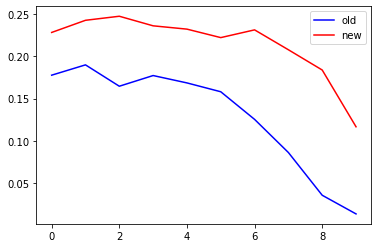

In [4]:
tmp = [0.1777292576419214, 0.18995633187772926, 0.1646288209606987, 0.17729257641921395, 0.1685589519650655, 0.15807860262008736, 0.12532751091703057, 0.08602620087336246, 0.035371179039301315, 0.013245033112582781]
precise = [0.22838427947598255, 0.24279475982532753, 0.24759825327510918, 0.23624454148471616, 0.23231441048034937, 0.22227074235807862, 0.2314410480349345, 0.20786026200873364, 0.18384279475982535, 0.11655629139072847]
x_data = [n for n in range(10)]
test, = plt.plot(x_data, tmp, color = 'blue')
fact, = plt.plot(x_data, precise, color = 'red')

plt.legend([test, fact], ['old', 'new'])
plt.savefig("precision.jpg")
plt.show()

In [8]:
print('1234' > '789')

False
